In [3]:
# Imports
import pandas as pd
from dotenv import load_dotenv
import os
import csv
import spacy 
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data processing

In [ ]:
load_dotenv()
filepath = os.getenv('FILEPATH')

**Reading the original dataset into Pandas dataframe and splitting the data into train (80), validation (10) and test (10) sets**

In [ ]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)


selected_columns = ["domain", "title", "authors", "type", "content", "url"]
sample_chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    sample_chunks.append(sample)
    df = pd.concat(sample_chunks, ignore_index=True)

train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training and temp for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("data/train_data.csv", chunksize=100000)
validation_dataframe.to_csv("data/validation_data.csv", chunksize=100000)
test_dataframe.to_csv("data/test_data.csv", chunksize=100000)

**Processing the data using SpaCy nlp library**

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()
csv.field_size_limit(100000000)

# I used chatgpt here for understanding how to use spacy and processing the texts in batches to make the processing more efficient
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["data/train_data.csv", "data/validation_data.csv", "data/test_data.csv"]
output_files = ["data/processed_train.csv", "data/processed_validation.csv", "data/processed_test.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

In [4]:
# Reading the processed csv files into Pandas Dataframes
df_train = pd.read_csv("data/processed/processed_train.csv")  
df_valid = pd.read_csv("data/processed/processed_validation.csv")
df_test = pd.read_csv("data/processed/processed_test.csv")  

### Computing reduction rates

In [ ]:

stats_path = "data/preprocessing_stats.txt"

if os.path.exists(stats_path): # checking if a statistics file already exists, so we don't have to do the analysis again
    print("Preprocessing stats already exist, reading from file\n")
    with open(stats_path, "r", encoding="utf-8") as f:
        print(f.read())
else: 
    original_vocab_size = len(original_vocab) 
    filtered_vocab_size = len(filtered_vocab_counter)
    lemmatized_vocab_size = len(lemmatized_vocab_counter)

    # reduction rate after stopword removal
    stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

    # calculating lemmatized reduction rate
    lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

    print(f"Original vocabulary size: {original_vocab_size}")
    print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
    print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
    print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
    print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

    with open("data/preprocessing_stats.txt", "w", encoding="utf-8") as f:
        f.write(f"Original vocabulary size: {original_vocab_size}\n")
        f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
        f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
        f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
        f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

    



In [53]:
print(df_train.head(10)) 

                                      processed_text  label        type  \
0  times cover widely regard major american fashi...      1    reliable   
1  dear reader excited announce voice russia chan...      0        bias   
2     late deliver daily friend think read newspaper      0   political   
3  receive natural health newsletter free subscri...      0     junksci   
4  break tradition budget year yes go deliver fal...      0      satire   
5  mark twain describe foul vilest obscene pictur...      0   political   
6  tor tor encrypt anonymise network make hard in...      0  unreliable   
7  tor tor encrypt anonymise network make hard in...      0  unreliable   
8  edit reason give find little concern fact apri...      0  conspiracy   
9  боевики обстреляли дагестанских омоновцев неиз...      0        bias   

               domain                                              title  \
0         nytimes.com  Gösta Peterson, Barrier-Breaking Fashion Photo...   
1     sputniknews.com 

### Exploring training data after preprocessing

**Precentage distribution of labels in the dataset**

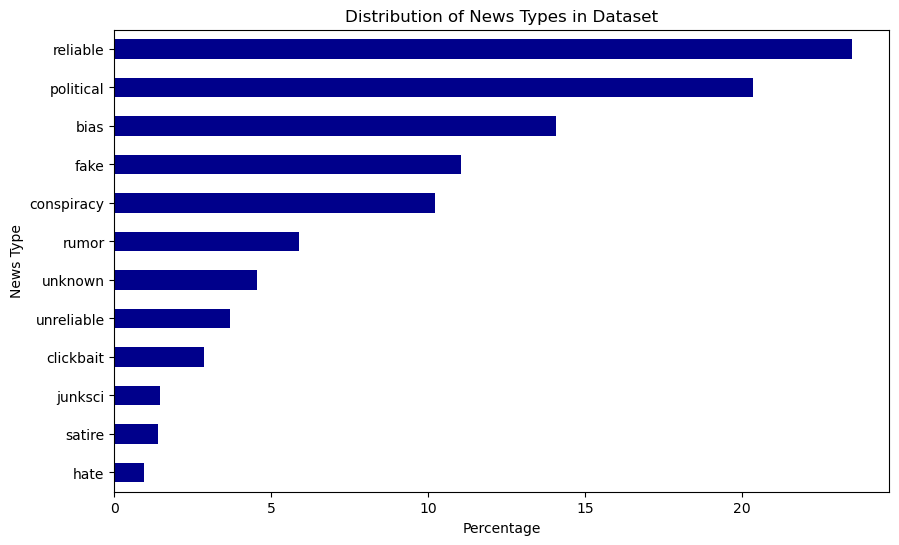

In [36]:
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

**Visualizing the distribution of words in reliable vs non-reliable news**

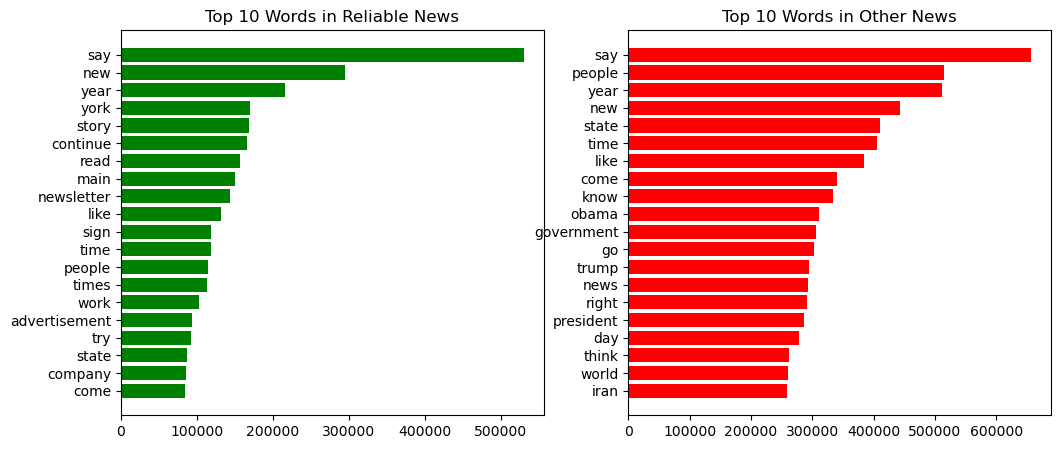

In [40]:
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter()
for text in reliable_texts:
    reliable_counter.update(text.split())

other_counter = Counter()
for text in other_texts:
    other_counter.update(text.split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()


**Average and median text lengths by news label (fake or reliable)**

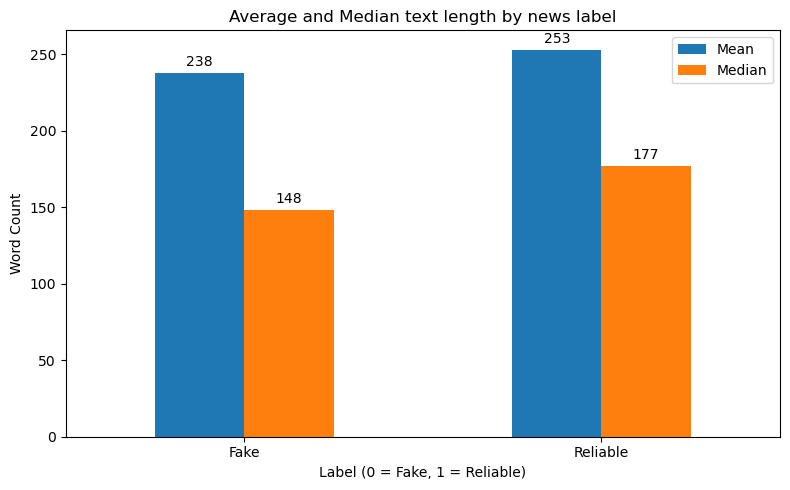

In [41]:
avg_md_stats = df_train.groupby("label")["text_length"].agg(["mean", "median"])

ax = avg_md_stats.plot(kind="bar", figsize=(8, 5))
plt.title("Average and Median text length by news label")
plt.xlabel("Label (0 = Fake, 1 = Reliable)")
plt.ylabel("Word Count")
plt.xticks(ticks=[0, 1], labels=["Fake", "Reliable"], rotation=0)
plt.legend(["Mean", "Median"])
plt.tight_layout()
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", padding=3)
plt.show()


**Pie chart of distribution between reliable vs fake news**

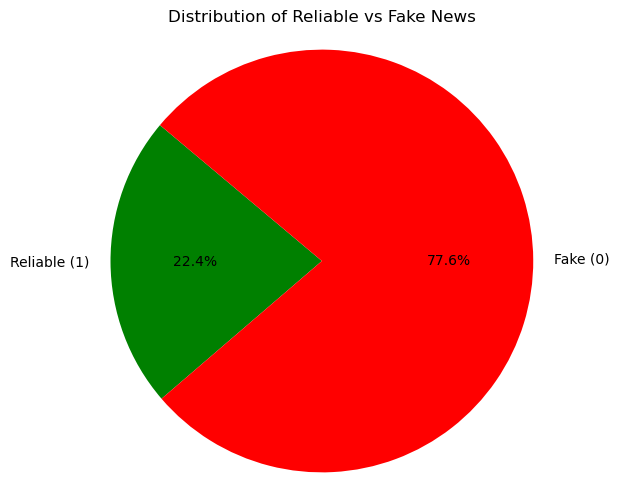

In [133]:
# counting reliable and fake news
label_counts = df_train["label"].value_counts()

# labels and sizes
labels = ["Reliable (1)", "Fake (0)"]
sizes = [label_counts.get(1, 0), label_counts.get(0, 0)] 
colors = ["green", "red"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
plt.title("Distribution of Reliable vs Fake News")
plt.axis("equal")
plt.show()


**Confusion matrix function**

In [5]:
# reference: https://www.w3schools.com/python/python_ml_confusion_matrix.asp
def confusion_matrix_fig(y_test, y_pred_test, title):
    cm = confusion_matrix(y_test, y_pred_test)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake (0)", "Real (1)"])
    disp.plot(cmap="Blues")  # You can change the colormap if you like
    plt.title(f"Confusion Matrix: {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Simple model development using Naive Bayes

In [6]:
# imports for simple model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

**Initial model using only the content and label for building the model**

In [9]:

x_train_sm = df_train["processed_text"].fillna("")
y_train_sm = df_train["label"]

x_valid_sm = df_valid["processed_text"].fillna("")
y_valid_sm = df_valid["label"]

x_test_sm = df_test["processed_text"].fillna("")
y_test_sm = df_test["label"]


In [10]:
# vectorizing using bigram TF-IDF
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))

x_train_vec = vectorizer.fit_transform(x_train_sm)
x_val_vec = vectorizer.transform(x_valid_sm)
x_test_vec = vectorizer.transform(x_test_sm)

In [11]:
# training the model
simple_model = MultinomialNB()
simple_model.fit(x_train_vec, y_train_sm)

MultinomialNB()

In [12]:
# evaluating with validation data
y_pred_val = simple_model.predict(x_val_vec)
print("Validation data accuracy:", accuracy_score(y_valid_sm, y_pred_val))
print(classification_report(y_valid_sm, y_pred_val))

Validation data accuracy: 0.8658592348547912
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66089
           1       0.99      0.41      0.58     19202

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.88      0.87      0.84     85291



Test data accuracy: 0.8672896319658581
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     66171
           1       1.00      0.41      0.58     19120

    accuracy                           0.87     85291
   macro avg       0.92      0.70      0.75     85291
weighted avg       0.89      0.87      0.84     85291



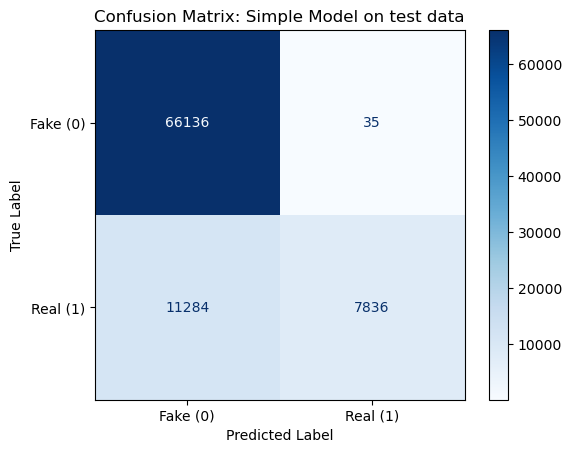

In [13]:
# evaluating with test data

y_pred_test = simple_model.predict(x_test_vec)
print("Test data accuracy:", accuracy_score(y_test_sm, y_pred_test))
print(classification_report(y_test_sm, y_pred_test))

confusion_matrix_fig(y_test_sm, y_pred_test, "Simple Model on test data")

### Using more metadata for the model

**Using domain and title for additional data to predict fake news**

In [14]:
domain_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
domain_encoded = domain_ohe.fit_transform(df_train[["domain"]])

title_vec = TfidfVectorizer(max_features=500, stop_words='english')
title_encoded = title_vec.fit_transform(df_train["title"].fillna(""))


In [15]:
x_combined = hstack([x_train_vec, domain_encoded, title_encoded])
y = df_train["label"]

In [16]:
meta_model = MultinomialNB()
meta_model.fit(x_combined, y)

MultinomialNB()

**Evaluating with validation data**

In [17]:
domain_encoded_valid = domain_ohe.transform(df_valid[["domain"]])
title_encoded_valid = title_vec.transform(df_valid["title"].fillna(""))

In [18]:
x_combined_val = hstack([x_val_vec, domain_encoded_valid, title_encoded_valid])

# evaluating
y_pred_val_meta = meta_model.predict(x_combined_val)

print("Validation data accuracy:", accuracy_score(y_valid_sm, y_pred_val_meta))
print(classification_report(y_valid_sm, y_pred_val_meta))

Validation data accuracy: 0.9887913144411485
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     66089
           1       1.00      0.95      0.97     19202

    accuracy                           0.99     85291
   macro avg       0.99      0.98      0.98     85291
weighted avg       0.99      0.99      0.99     85291



**Finally with test data**

In [19]:
domain_encoded_test = domain_ohe.transform(df_test[["domain"]])
title_encoded_test = title_vec.transform(df_test["title"].fillna(""))

Test data accuracy: 0.9881699124174884
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     66171
           1       1.00      0.95      0.97     19120

    accuracy                           0.99     85291
   macro avg       0.99      0.97      0.98     85291
weighted avg       0.99      0.99      0.99     85291



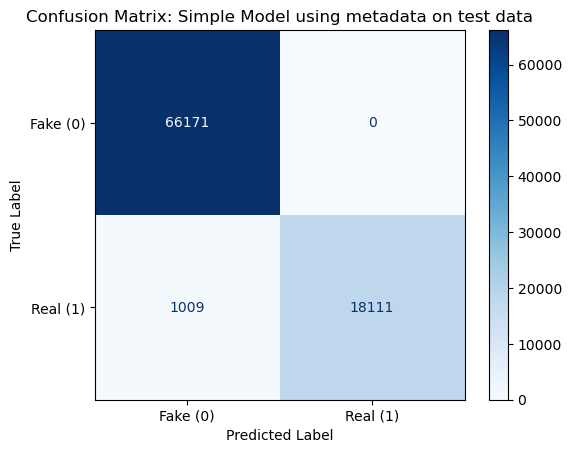

In [21]:
x_combined_test = hstack([x_test_vec, domain_encoded_test, title_encoded_test])

# evaluating
y_pred_meta = meta_model.predict(x_combined_test)

print("Test data accuracy:", accuracy_score(y_test_sm, y_pred_meta))
print(classification_report(y_test_sm, y_pred_meta))

confusion_matrix_fig(y_test_sm, y_pred_meta, "Simple Model using metadata on test data")

**saving models**

In [ ]:
import joblib

# Save the model
#joblib.dump(model, "models/simple_model.joblib")
joblib.dump(meta_model, "models/simple_model_meta.joblib")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "models/tfidf_bigrams_vectorizer.joblib")

# Avanced model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping
import pickle

In [ ]:
MAX_WORDS=10000
MAX_LEN=100
LSTM_UNITS=128 # before finetuning: 64
NUM_CLASSES=1 # 1 class bc its binary classification

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

model = load_model("models/advanced_model.keras")


### Training the LSTM model

In [26]:
x_train = df_train["processed_text"].fillna("").astype(str).tolist()
y_train = df_train["label"].values

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")

# reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

with open("models/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 100)) # before finetuning: 32
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(0.5)) # added for finetuning
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [30]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training the model

# monitoring validation loss stops the model if performance stops improving and 
# helps prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# validation_split splits 20% off from training data to validation, needed for the callback
model.fit(xTrain, y_train, batch_size=32, epochs=15, validation_split=0.2, callbacks=[early_stop])

Epoch 1/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 742s 43ms/step - accuracy: 0.9529 - loss: 0.1234 - val_accuracy: 0.9536 - val_loss: 0.1214
Epoch 2/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 737s 43ms/step - accuracy: 0.9617 - loss: 0.1003 - val_accuracy: 0.9522 - val_loss: 0.1251
Epoch 3/15
17059/17059 ━━━━━━━━━━━━━━━━━━━━ 765s 45ms/step - accuracy: 0.9691 - loss: 0.0822 - val_accuracy: 0.9502 - val_loss: 0.1358


In [34]:
model.save("models/advanced_model_finetuned.keras")  # saving model for later use

### Validating

In [ ]:
x_valid = df_valid["processed_text"].fillna("").astype(str).tolist()
y_valid = df_valid["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))



2666/2666 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     66089
           1       0.92      0.85      0.88     19202

    accuracy                           0.95     85291
   macro avg       0.94      0.91      0.92     85291
weighted avg       0.95      0.95      0.95     85291

Accuracy: 0.9488926146955716
Precision: 0.9184191238653662
Recall: 0.8483491302989272
F1-score: 0.8819946398115812


### Evaluating the model

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     66171
           1       0.92      0.85      0.88     19120

    accuracy                           0.95     85291
   macro avg       0.94      0.91      0.92     85291
weighted avg       0.95      0.95      0.95     85291

Accuracy: 0.9486346742329202
Precision: 0.9150194289575941
Recall: 0.8497907949790795
F1-score: 0.881199663747051
2666/2666 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.9483 - loss: 0.1330
Test Loss: 0.1319
Test Accuracy: 0.9486


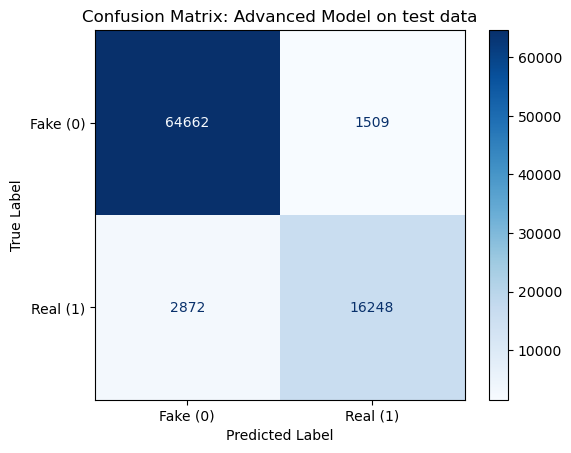

In [36]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# replacing empty arrays to [1] since pad_sequences thorws error on empty sequence arrays
sequences = [seq if seq else [1] for seq in sequences]

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xTest)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_test, y_pred))

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

confusion_matrix_fig(y_test, y_pred, "Advanced Model on test data")

# Testing models with LIAR dataset

**Preprocessing the LIAR data**

In [37]:
liar_test_filepath = "data/liar/test.tsv"
liar_valid_filepath = "data/liar/valid.tsv"
liar_train_filepath = "data/liar/train.tsv"
 
# convert liar data to csv
# liar headers
liar_headers= ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"]
# convert liar data to csv
liar_test_df = pd.read_csv(liar_test_filepath, sep="\t", header=None, names=liar_headers)
liar_valid_df = pd.read_csv(liar_valid_filepath, sep="\t", header=None, names=liar_headers)
liar_train_df = pd.read_csv(liar_train_filepath, sep="\t", header=None, names=liar_headers)
 
liar_test_df.to_csv("data/liar/test.csv", index=False)
liar_valid_df.to_csv("data/liar/valid.csv", index=False)
liar_train_df.to_csv("data/liar/train.csv", index=False)
 
# labels in liar = true, false, half-true, pants-fire, barely-true, mostly-true
# only true and mostly-true are true others are false
# converting labels to binary 1=true, 0=false
liar_selected_columns = ["label", "subject", "statement"]
 
input_files = ["data/liar/train.csv", "data/liar/test.csv", "data/liar/valid.csv"]
output_files = ["data/liar/train_processed.csv", "data/liar/test_processed.csv", "data/liar/valid_processed.csv"]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
def preprocess_liar(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=liar_selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["bin_label"] = chunk["label"].apply(lambda x: 1 if str(x).strip().lower() in ["true", "mostly-true"] else 0)
            # collecting yields into a list
            texts = chunk["statement"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess_liar(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk
            chunk["domain"] = chunk["subject"].fillna("unknown")
            chunk["title"] = chunk["statement"]

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "bin_label", "subject", "label", "title", "domain"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing data/liar/train.csv
Chunk processed in 11.30s
Chunk processed in 9.92s
Chunk processed in 12.03s
Chunk processed in 10.20s
Chunk processed in 10.08s
Chunk processed in 10.41s
Chunk processed in 11.06s
Chunk processed in 10.67s
Chunk processed in 10.62s
Chunk processed in 10.42s
Processing data/liar/test.csv
Chunk processed in 10.61s
Chunk processed in 9.31s
Processing data/liar/valid.csv
Chunk processed in 10.66s
Chunk processed in 10.23s
Preprocessing done.


In [38]:
df_valid_liar = pd.read_csv("data/liar/valid_processed.csv")  
df_test_liar = pd.read_csv("data/liar/test_processed.csv") 
df_train_liar = pd.read_csv("data/liar/train_processed.csv") 

### Simple model with LIAR

**Without metadata**

In [39]:
x_valid_liar = df_valid_liar["processed_text"].fillna("")
y_valid_liar = df_valid_liar["bin_label"]

x_test_liar = df_test_liar["processed_text"].fillna("")
y_test_liar = df_test_liar["bin_label"]

x_train_liar = df_train_liar["processed_text"].fillna("")
y_train_liar = df_train_liar["bin_label"]


x_val_vec_liar = vectorizer.transform(x_valid_liar)
x_test_vec_liar = vectorizer.transform(x_test_liar)
x_train_vec_liar = vectorizer.transform(x_train_liar)

**Evaluating with train, validation and test datasets**

In [40]:
y_pred_train_liar = simple_model.predict(x_train_vec_liar)
print("Train data accuracy for validation data in simple model:", accuracy_score(y_train_liar, y_pred_train_liar))
print(classification_report(y_train_liar, y_pred_train_liar, zero_division=0))

Train data accuracy for validation data in simple model: 0.64482421875
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      6602
           1       0.67      0.00      0.00      3638

    accuracy                           0.64     10240
   macro avg       0.66      0.50      0.39     10240
weighted avg       0.65      0.64      0.51     10240



In [41]:
y_pred_val_liar = simple_model.predict(x_val_vec_liar)
print("Validation data accuracy for validation data in simple model:", accuracy_score(y_valid_liar, y_pred_val_liar))
print(classification_report(y_valid_liar, y_pred_val_liar, zero_division=0))

Validation data accuracy for validation data in simple model: 0.6728971962616822
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       864
           1       0.00      0.00      0.00       420

    accuracy                           0.67      1284
   macro avg       0.34      0.50      0.40      1284
weighted avg       0.45      0.67      0.54      1284



In [43]:
y_pred_test_liar = simple_model.predict(x_test_vec_liar)
print("Test data accuracy in simple model:", accuracy_score(y_test_liar, y_pred_test_liar))
print(classification_report(y_test_liar, y_pred_test_liar, zero_division=0))

Test data accuracy in simple model: 0.6456195737963694
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.00      0.00      0.00       449

    accuracy                           0.65      1267
   macro avg       0.32      0.50      0.39      1267
weighted avg       0.42      0.65      0.51      1267



**Simple model with metadata**

In [44]:
domain_encoded_train_liar = domain_ohe.transform(df_train_liar[["domain"]])
title_encoded_train_liar = title_vec.transform(df_train_liar["title"].fillna(""))

x_combined_train_liar = hstack([x_train_vec_liar, domain_encoded_train_liar, title_encoded_train_liar])

# evaluating
y_pred_train_liar = meta_model.predict(x_combined_train_liar)

print("Training data accuracy for meta-model using LIAR:", accuracy_score(y_train_liar, y_pred_train_liar))
print(classification_report(y_train_liar, y_pred_train_liar, zero_division=0))

Training data accuracy for meta-model using LIAR: 0.6451171875
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      6602
           1       0.83      0.00      0.00      3638

    accuracy                           0.65     10240
   macro avg       0.74      0.50      0.39     10240
weighted avg       0.71      0.65      0.51     10240



In [45]:
domain_encoded_valid_liar = domain_ohe.transform(df_valid_liar[["domain"]])
title_encoded_valid_liar = title_vec.transform(df_valid_liar["title"].fillna(""))

x_combined_val_liar = hstack([x_val_vec_liar, domain_encoded_valid_liar, title_encoded_valid_liar])

# evaluating
y_pred_val_liar = meta_model.predict(x_combined_val_liar)

print("Validation data accuracy for meta-model using LIAR:", accuracy_score(y_valid_liar, y_pred_val_liar))
print(classification_report(y_valid_liar, y_pred_val_liar, zero_division=0))

Validation data accuracy for meta-model using LIAR: 0.6721183800623053
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       864
           1       0.00      0.00      0.00       420

    accuracy                           0.67      1284
   macro avg       0.34      0.50      0.40      1284
weighted avg       0.45      0.67      0.54      1284



In [46]:
domain_encoded_test_liar = domain_ohe.transform(df_test_liar[["domain"]])
title_encoded_test_liar = title_vec.transform(df_test_liar["title"].fillna(""))

x_combined_test_liar = hstack([x_test_vec_liar, domain_encoded_test_liar, title_encoded_test_liar])

# evaluating
y_pred_test_liar = meta_model.predict(x_combined_test_liar)

print("Test data accuracy for meta-model using LIAR:", accuracy_score(y_test_liar, y_pred_test_liar))
print(classification_report(y_test_liar, y_pred_test_liar, zero_division=0))

Test data accuracy for meta-model using LIAR: 0.6456195737963694
              precision    recall  f1-score   support

           0       0.65      1.00      0.78       818
           1       0.00      0.00      0.00       449

    accuracy                           0.65      1267
   macro avg       0.32      0.50      0.39      1267
weighted avg       0.42      0.65      0.51      1267



### Advanced model with LIAR

**Training data from liar**

In [47]:
x_liar_train = df_train_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_train = df_train_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_train)

# padding sequences make all sequences the same length
xLiarTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_train = model.predict(xLiarTrain)
y_pred_train = (y_pred_probs_train >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_train, y_pred_train))

loss, accuracy = model.evaluate(xLiarTrain, y_pred_train)
print(f"LIAR Train Loss: {loss:.4f}")
print(f"LIAR Train Accuracy: {accuracy:.4f}")


320/320 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
              precision    recall  f1-score   support

           0       0.65      0.98      0.78      6602
           1       0.42      0.03      0.06      3638

    accuracy                           0.64     10240
   macro avg       0.53      0.50      0.42     10240
weighted avg       0.57      0.64      0.52     10240

320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 1.0000 - loss: 0.0805
LIAR Train Loss: 0.0778
LIAR Train Accuracy: 1.0000


**Valid data from liar**

In [48]:
x_liar_valid = df_valid_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_valid = df_valid_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_valid)

# padding sequences make all sequences the same length
xLiarValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_valid = model.predict(xLiarValid)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_valid, y_pred_valid))

loss, accuracy = model.evaluate(xLiarValid, y_liar_valid)
print(f"LIAR Validation Loss: {loss:.4f}")
print(f"LIAR Validation Accuracy: {accuracy:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       864
           1       0.38      0.04      0.07       420

    accuracy                           0.67      1284
   macro avg       0.52      0.50      0.43      1284
weighted avg       0.58      0.67      0.56      1284

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6723 - loss: 1.2757
LIAR Validation Loss: 1.2975
LIAR Validation Accuracy: 0.6651


**Test data from liar**

In [49]:
x_liar_test = df_test_liar["processed_text"].fillna("").astype(str).tolist()
y_liar_test = df_test_liar["bin_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_test)

# padding sequences make all sequences the same length
xLiarTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_test = model.predict(xLiarTest)
y_pred_test = (y_pred_probs_test >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_test, y_pred_test))

loss, accuracy = model.evaluate(xLiarTest, y_liar_test)
print(f"LIAR Test Loss: {loss:.4f}")
print(f"LIAR Test Accuracy: {accuracy:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       0.65      0.98      0.78       818
           1       0.61      0.05      0.09       449

    accuracy                           0.65      1267
   macro avg       0.63      0.52      0.44      1267
weighted avg       0.64      0.65      0.54      1267

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6610 - loss: 1.3221
LIAR Test Loss: 1.3476
LIAR Test Accuracy: 0.6519
